In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
import shap

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
first_items_list = os.listdir(path)

In [4]:
first_items_list

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'test.parquet',
 'train.parquet']

In [5]:
# https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost
# edited by Max (Jongyun Han)

def reduce_mem_usage(df, float16_as32=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in tqdm(df.columns):
        col_type = df[col].dtype
        if col_type != object and str(col_type)!='category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == 'float':
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
            elif str(col_type)[:4] == 'bool':
                continue
            else:
                raise 'unknown datatype'
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df.copy()

In [6]:
def read_parquet_files(train_or_test='train'):
    pq_folders_path = path + f"{train_or_test}.parquet/"
    folders_list = os.listdir(pq_folders_path)

    pq_list = []
    
    for folder in tqdm(folders_list):
        files_path = pq_folders_path + '/' + folder
        files_list = os.listdir(files_path)
        for file in files_list:
            if '.parquet' in file:
                pq_df = pd.read_parquet(files_path + '/' + file)

                if train_or_test == 'train':
                    cols_to_drop = [col for col in pq_df.columns if 'responder' in col]
                    cols_to_drop.remove('responder_6')
                    pq_df = pq_df.drop(cols_to_drop, axis=1)
                
                pq_list.append(pq_df)

    return reduce_mem_usage(pd.concat(pq_list, ignore_index=True), False)

In [7]:
train_scan = pl.scan_parquet(path + 'train.parquet/')
test_scan = pl.scan_parquet(path + 'test.parquet/')

In [8]:
train_symbol_ids_list = sorted(train_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(train_symbol_ids_list))
train_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [9]:
test_symbol_ids_list = sorted(test_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(test_symbol_ids_list))
test_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [10]:
unique_symbol_ids_list = sorted(list(set(train_symbol_ids_list + test_symbol_ids_list)))
print(len(unique_symbol_ids_list))
unique_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [11]:
train_df = read_parquet_files()
y_sr = train_df['responder_6']
train_df = train_df.drop('responder_6', axis=1)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.04s/it]


Memory usage of dataframe is 14427.07 MB


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:28<00:00,  2.97it/s]


Memory usage after optimization is: 7415.78 MB
Decreased by 48.6%
(47127338, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143
4,0,0,14,0.440674,NaN,NaN,NaN,NaN,NaN,0.955078,0.262451,0.344482,-0.613770,44,3,16,-0.947266,-0.030014,-0.502441,NaN,0.645996,NaN,-1.844727,-1.586914,-0.182007,NaN,-0.969727,-0.673828,-1.282227,-1.399414,NaN,NaN,0.043823,-0.320312,-0.031708,NaN,NaN,NaN,-0.088440,-0.995117,-2.634766,-0.196411,-0.618652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.013672,-2.320312,-3.710938,NaN,1.253906,NaN,NaN,0.476074,NaN,-0.771973,2.843750,NaN,1.379883,0.411865,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.948730,-0.136841,-0.447754,-1.141602,0.099609,-0.662109,NaN,NaN,3.677734,2.792969,2.619141,3.417969


In [12]:
test_df = read_parquet_files(train_or_test='test')
test_row_id_sr = test_df['row_id']
test_df = test_df.drop(['row_id', 'is_scored'], axis=1)
print(test_df.shape)
test_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.11it/s]


Memory usage of dataframe is 0.01 MB


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 2396.68it/s]

Memory usage after optimization is: 0.01 MB
Decreased by 26.0%
(39, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
5,0,0,5,2.605469,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
6,0,0,6,1.047852,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
7,0,0,7,4.230469,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
8,0,0,8,2.599609,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,

In [13]:
lags_df = read_parquet_files(train_or_test='lags')
print(lags_df.shape)
lags_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.82it/s]


Memory usage of dataframe is 0.00 MB


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2310.81it/s]

Memory usage after optimization is: 0.00 MB
Decreased by 45.1%
(39, 12)


,date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,0,-0.442139,-0.322510,0.143555,-0.926758,-0.782227,-0.036591,-1.305664,-0.795898,-0.143677
1,0,0,1,-0.651855,-1.708008,-0.894043,-1.065430,-1.871094,-0.615723,-1.163086,-1.206055,-1.246094
2,0,0,2,-0.656250,-0.264648,-0.893066,-1.511719,-1.033203,-0.378174,-1.574219,-1.863281,-0.027344
3,0,0,3,-0.188232,-0.190918,-0.701660,0.098450,-1.015625,-0.054993,0.329102,-0.965332,0.576660
4,0,0,4,-0.257568,-0.471436,-0.297363,0.074036,-0.324219,-0.597168,0.219849,-0.276367,-0.904785
5,0,0,5,0.027573,-0.020172,0.640137,-0.948242,-0.374268,-0.240356,-0.913574,-0.548828,-1.284180
6,0,0,6,-0.419678,-0.181274,-0.194092,0.667969,0.937012,0.517578,0.896484,1.069336,1.579102
7,0,0,7,-0.114136,-0.198486,-0.200073,-0.409912,-0.135132,-0.182861,-0.492188,-0.142944,-0.202026
8,0,0,8,-0.374268,0.092102,0.294678,0.403076,2.060547,-0.225098,0.956543,2.185547,-0.435791
9,0,0,9,-0.529297,0.040100,-0.333008,-0.958984,-1.318359,-0.774414,-0.716309,-1.471680,-1.107422


In [14]:
sample_df = pd.read_csv(path + 'sample_submission.csv')
print(sample_df.shape)
sample_df

(39, 2)


,row_id,responder_6
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [15]:
def one_hot_cat_cols(df):
    for v in tqdm(unique_symbol_ids_list):
        new_col_name = 'symbol_id_' + str(v)
        df[new_col_name] = (df['symbol_id'] == v).astype(int)
    
    #df = df.drop('symbol_id', axis=1)

    return

In [16]:
#one_hot_cat_cols(train_df)
#print(train_df.shape)
#train_df.head()

In [17]:
#one_hot_cat_cols(test_df)
#print(test_df.shape)
#test_df.head()

In [18]:
feature_cols = [col for col in train_df.columns if 'feature' in col]
print(len(feature_cols))
feature_cols

79


['feature_00',
 'feature_01',
 'feature_02',
 'feature_03',
 'feature_04',
 'feature_05',
 'feature_06',
 'feature_07',
 'feature_08',
 'feature_09',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_

In [19]:
sample_train_df = train_df.sample(frac=0.001)
print(sample_train_df.shape)

(47127, 83)


In [20]:
sample_y_sr = y_sr.loc[sample_train_df.index]
print(sample_y_sr.shape)

(47127,)


In [21]:
def times_cols():

    past_cols_list = []
    better_cols_list = []
    target_cols = []
    for col in tqdm(feature_cols):
        for second_col in feature_cols:
            if col != second_col:
                together_cols = col + '*' + second_col
                together_cols2 = second_col + '*' + col
                if together_cols not in past_cols_list:
                    past_cols_list.append(together_cols)
                if together_cols2 not in past_cols_list:
                    past_cols_list.append(together_cols2)
                    target_cols.append(together_cols)
                    first_sr = sample_train_df[col].dropna()
                    second_sr = sample_train_df[second_col].dropna()
                    first_sr_corr = np.abs(np.corrcoef(first_sr, sample_y_sr.loc[first_sr.index]))[0][1]
                    combined_sr = (first_sr * second_sr).replace([np.inf, -np.inf], np.nan).dropna()
                    combined_corr = np.abs(np.corrcoef(combined_sr, sample_y_sr.loc[combined_sr.index]))[0][1]
                    if (combined_corr / first_sr_corr) >= 1.1:
                        better_cols_list.append(together_cols)

    return better_cols_list

In [22]:
times_cols_list = times_cols()

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.62it/s]


In [23]:
len(times_cols_list)

1352

In [24]:
times_cols_list

['feature_00*feature_02',
 'feature_00*feature_03',
 'feature_00*feature_04',
 'feature_00*feature_05',
 'feature_00*feature_06',
 'feature_00*feature_07',
 'feature_00*feature_12',
 'feature_00*feature_13',
 'feature_00*feature_14',
 'feature_00*feature_18',
 'feature_00*feature_19',
 'feature_00*feature_26',
 'feature_00*feature_33',
 'feature_00*feature_36',
 'feature_00*feature_37',
 'feature_00*feature_38',
 'feature_00*feature_42',
 'feature_00*feature_43',
 'feature_00*feature_44',
 'feature_00*feature_45',
 'feature_00*feature_46',
 'feature_00*feature_47',
 'feature_00*feature_48',
 'feature_00*feature_49',
 'feature_00*feature_53',
 'feature_00*feature_54',
 'feature_00*feature_55',
 'feature_00*feature_56',
 'feature_00*feature_57',
 'feature_00*feature_58',
 'feature_00*feature_59',
 'feature_00*feature_60',
 'feature_00*feature_62',
 'feature_00*feature_63',
 'feature_00*feature_64',
 'feature_00*feature_65',
 'feature_00*feature_66',
 'feature_00*feature_67',
 'feature_00

In [25]:
def divide_cols():

    past_cols_list = []
    better_cols_list2 = []
    target_cols = []
    for col in tqdm(feature_cols):
        for second_col in feature_cols:
            if col != second_col:
                together_cols = col + '/' + second_col
                together_cols2 = second_col + '/' + col
                if together_cols not in past_cols_list:
                    past_cols_list.append(together_cols)
                if together_cols2 not in past_cols_list:
                    past_cols_list.append(together_cols2)
                    target_cols.append(together_cols)
                    first_sr = sample_train_df[col].dropna()
                    second_sr = sample_train_df[second_col].dropna()
                    first_sr_corr = np.abs(np.corrcoef(first_sr, sample_y_sr.loc[first_sr.index]))[0][1]
                    combined_sr = (first_sr / second_sr).replace([np.inf, -np.inf], np.nan).dropna()
                    combined_corr = np.abs(np.corrcoef(combined_sr, sample_y_sr.loc[combined_sr.index]))[0][1]
                    if (combined_corr / first_sr_corr) >= 1.1:
                        better_cols_list2.append(together_cols)

    return better_cols_list2

In [26]:
divide_cols_list = divide_cols()

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.62it/s]


In [27]:
len(divide_cols_list)

665

In [28]:
divide_cols_list

['feature_00/feature_02',
 'feature_00/feature_06',
 'feature_00/feature_09',
 'feature_00/feature_11',
 'feature_00/feature_18',
 'feature_00/feature_21',
 'feature_00/feature_25',
 'feature_00/feature_31',
 'feature_00/feature_37',
 'feature_00/feature_39',
 'feature_00/feature_40',
 'feature_00/feature_43',
 'feature_00/feature_62',
 'feature_00/feature_63',
 'feature_00/feature_68',
 'feature_00/feature_73',
 'feature_00/feature_75',
 'feature_01/feature_26',
 'feature_01/feature_39',
 'feature_02/feature_06',
 'feature_02/feature_09',
 'feature_02/feature_11',
 'feature_02/feature_21',
 'feature_02/feature_25',
 'feature_02/feature_62',
 'feature_02/feature_73',
 'feature_03/feature_06',
 'feature_03/feature_09',
 'feature_03/feature_15',
 'feature_03/feature_19',
 'feature_03/feature_21',
 'feature_03/feature_25',
 'feature_03/feature_30',
 'feature_03/feature_31',
 'feature_03/feature_35',
 'feature_03/feature_39',
 'feature_03/feature_41',
 'feature_03/feature_43',
 'feature_03

In [29]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [30]:
def times_change_df():
    for col in tqdm(times_cols_list):
        col1 = col.split('*')[0]
        col2 = col.split('*')[1]
    
        sample_train_df[col] = sample_train_df[col1] * sample_train_df[col2]

    return

def divide_change_df():
    for col in tqdm(divide_cols_list):
        col1 = col.split('/')[0]
        col2 = col.split('/')[1]
    
        sample_train_df[col] = (sample_train_df[col1] / sample_train_df[col2]).replace([np.inf, -np.inf], np.nan)

    return

In [31]:
times_change_df()

100%|████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:01<00:00, 1250.65it/s]


In [32]:
divide_change_df()

100%|███████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<00:00, 765.90it/s]


In [33]:
sample_train_df = reduce_mem_usage(sample_train_df)

Memory usage of dataframe is 197.59 MB


100%|████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:02<00:00, 1032.75it/s]


Memory usage after optimization is: 192.56 MB
Decreased by 2.5%


In [34]:
print(sample_train_df.shape)

(47127, 2100)


In [40]:
def corr_values():
    corrs_list = []
    for col in tqdm(sample_train_df.columns):
        col_sr = sample_train_df[col].dropna()
        nonan_y_sr = sample_y_sr.loc[col_sr.index]
        temp_corr = np.abs(np.corrcoef(col_sr, nonan_y_sr)[0][1])
        corrs_list.append(temp_corr)

    temp_df = pd.DataFrame({'cols':sample_train_df.columns.tolist(), 'corr_values':corrs_list}).sort_values('corr_values', ascending=False)

    return temp_df.head(50)

In [41]:
corr_values_df = corr_values()

100%|█████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 489.32it/s]


In [42]:
corr_values_df

,cols,corr_values
10,feature_06,0.047062
11,feature_07,0.037043
203,feature_05*feature_11,0.034699
205,feature_08*feature_37,0.034431
1421,feature_71*feature_77,0.033324
400,feature_14*feature_57,0.033030
40,feature_36,0.032713
1256,feature_50*feature_59,0.032041
394,feature_14*feature_46,0.031925
1171,feature_44*feature_78,0.031349


In [43]:
sample_train_df = train_df.iloc[:train_df.shape[0]//10,:]
print(sample_train_df.shape)
sample_train_df.head()

(4712733, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143
4,0,0,14,0.440674,NaN,NaN,NaN,NaN,NaN,0.955078,0.262451,0.344482,-0.613770,44,3,16,-0.947266,-0.030014,-0.502441,NaN,0.645996,NaN,-1.844727,-1.586914,-0.182007,NaN,-0.969727,-0.673828,-1.282227,-1.399414,NaN,NaN,0.043823,-0.320312,-0.031708,NaN,NaN,NaN,-0.088440,-0.995117,-2.634766,-0.196411,-0.618652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.013672,-2.320312,-3.710938,NaN,1.253906,NaN,NaN,0.476074,NaN,-0.771973,2.843750,NaN,1.379883,0.411865,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.948730,-0.136841,-0.447754,-1.141602,0.099609,-0.662109,NaN,NaN,3.677734,2.792969,2.619141,3.417969


In [44]:
sample_y_sr = y_sr.loc[sample_train_df.index]
print(sample_y_sr.shape)
sample_y_sr.head()

(4712733,)


0    0.775879
1    0.703613
2    2.109375
3    1.114258
4   -3.572266
Name: responder_6, dtype: float16

In [53]:
def train_times_change_df():
    for col in tqdm(times_cols_list):
        if col in corr_values_df['cols'].tolist():
            col1 = col.split('*')[0]
            col2 = col.split('*')[1]
        
            train_df[col] = train_df[col1] * train_df[col2]

    return

def train_divide_change_df():
    for col in tqdm(divide_cols_list):
        if col in corr_values_df['cols'].tolist():
            col1 = col.split('/')[0]
            col2 = col.split('/')[1]
        
            train_df[col] = (train_df[col1] / train_df[col2]).replace([np.inf, -np.inf], np.nan)

    return

In [54]:
train_times_change_df()

100%|██████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:23<00:00, 58.75it/s]


In [55]:
train_divide_change_df()

100%|████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<00:00, 371300.87it/s]


In [56]:
print(train_df.shape)

(47127338, 128)


In [57]:
train_df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_05*feature_10,feature_05*feature_11,feature_08*feature_37,feature_09*feature_36,feature_11*feature_36,feature_12*feature_55,feature_12*feature_58,feature_12*feature_60,feature_13*feature_37,feature_13*feature_57,feature_13*feature_58,feature_13*feature_77,feature_14*feature_37,feature_14*feature_42,feature_14*feature_46,feature_14*feature_55,feature_14*feature_57,feature_14*feature_60,feature_16*feature_53,feature_16*feature_58,feature_27*feature_69,feature_37*feature_38,feature_38*feature_71,feature_44*feature_77,feature_44*feature_78,feature_46*feature_69,feature_47*feature_67,feature_50*feature_59,feature_52*feature_69,feature_53*feature_59,feature_53*feature_77,feature_53*feature_78,feature_55*feature_67,feature_55*feature_73,feature_55*feature_77,feature_55*feature_78,feature_56*feature_59,feature_57*feature_69,feature_58*feature_67,feature_58*feature_71,feature_60*feature_67,feature_60*feature_70,feature_60*feature_71,feature_71*feature_77,feature_71*feature_78
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,5.957031,64.681641,0.011230,3.839844,26.533203,NaN,NaN,0.304688,-0.000039,0.002232,NaN,-0.001029,0.009377,NaN,NaN,NaN,-0.541504,0.257080,NaN,NaN,NaN,0.002846,-0.034393,NaN,NaN,NaN,-0.705566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.015625,-0.357422,NaN,NaN,0.431885,0.353027,-0.052551,-0.051056,-0.042847
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,4.738281,51.433594,0.043213,-20.062500,-138.566406,NaN,NaN,-0.405029,0.018677,-0.239868,NaN,0.055420,0.048157,NaN,NaN,NaN,-0.619141,-0.272461,NaN,NaN,NaN,0.015236,0.072510,NaN,NaN,NaN,11.546875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.252930,-0.630371,NaN,NaN,-0.498535,-0.492676,-0.184326,0.096741,0.119141
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515

In [63]:
sample_train_df = train_df.iloc[:train_df.shape[0]//10,:].reset_index(drop=True)
print(sample_train_df.shape)
sample_train_df.head()

(4712733, 128)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_05*feature_10,feature_05*feature_11,feature_08*feature_37,feature_09*feature_36,feature_11*feature_36,feature_12*feature_55,feature_12*feature_58,feature_12*feature_60,feature_13*feature_37,feature_13*feature_57,feature_13*feature_58,feature_13*feature_77,feature_14*feature_37,feature_14*feature_42,feature_14*feature_46,feature_14*feature_55,feature_14*feature_57,feature_14*feature_60,feature_16*feature_53,feature_16*feature_58,feature_27*feature_69,feature_37*feature_38,feature_38*feature_71,feature_44*feature_77,feature_44*feature_78,feature_46*feature_69,feature_47*feature_67,feature_50*feature_59,feature_52*feature_69,feature_53*feature_59,feature_53*feature_77,feature_53*feature_78,feature_55*feature_67,feature_55*feature_73,feature_55*feature_77,feature_55*feature_78,feature_56*feature_59,feature_57*feature_69,feature_58*feature_67,feature_58*feature_71,feature_60*feature_67,feature_60*feature_70,feature_60*feature_71,feature_71*feature_77,feature_71*feature_78
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,5.957031,64.681641,0.011230,3.839844,26.533203,NaN,NaN,0.304688,-0.000039,0.002232,NaN,-0.001029,0.009377,NaN,NaN,NaN,-0.541504,0.257080,NaN,NaN,NaN,0.002846,-0.034393,NaN,NaN,NaN,-0.705566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.015625,-0.357422,NaN,NaN,0.431885,0.353027,-0.052551,-0.051056,-0.042847
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,4.738281,51.433594,0.043213,-20.062500,-138.566406,NaN,NaN,-0.405029,0.018677,-0.239868,NaN,0.055420,0.048157,NaN,NaN,NaN,-0.619141,-0.272461,NaN,NaN,NaN,0.015236,0.072510,NaN,NaN,NaN,11.546875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.252930,-0.630371,NaN,NaN,-0.498535,-0.492676,-0.184326,0.096741,0.119141
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515

In [64]:
sample_y_sr = y_sr.loc[sample_train_df.index].reset_index(drop=True)
print(sample_y_sr.shape)
sample_y_sr.head()

(4712733,)


0    0.775879
1    0.703613
2    2.109375
3    1.114258
4   -3.572266
Name: responder_6, dtype: float16

In [65]:
one_hot_cat_cols(sample_train_df)
sample_train_df = reduce_mem_usage(sample_train_df)
print(sample_train_df.shape)
sample_train_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 127.97it/s]


Memory usage of dataframe is 1856.19 MB


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:08<00:00, 18.76it/s]


Memory usage after optimization is: 1447.20 MB
Decreased by 22.0%
(4712733, 167)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_05*feature_10,feature_05*feature_11,feature_08*feature_37,feature_09*feature_36,feature_11*feature_36,feature_12*feature_55,feature_12*feature_58,feature_12*feature_60,feature_13*feature_37,feature_13*feature_57,feature_13*feature_58,feature_13*feature_77,feature_14*feature_37,feature_14*feature_42,feature_14*feature_46,feature_14*feature_55,feature_14*feature_57,feature_14*feature_60,feature_16*feature_53,feature_16*feature_58,feature_27*feature_69,feature_37*feature_38,feature_38*feature_71,feature_44*feature_77,feature_44*feature_78,feature_46*feature_69,feature_47*feature_67,feature_50*feature_59,feature_52*feature_69,feature_53*feature_59,feature_53*feature_77,feature_53*feature_78,feature_55*feature_67,feature_55*feature_73,feature_55*feature_77,feature_55*feature_78,feature_56*feature_59,feature_57*feature_69,feature_58*feature_67,feature_58*feature_71,feature_60*feature_67,feature_60*feature_70,feature_60*feature_71,feature_71*feature_77,feature_71*feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,5.957031,64.68750,0.011230,3.839844,26.53125,NaN,NaN,0.304688,-0.000039,0.002232,NaN,-0.001029,0.009377,NaN,NaN,NaN,-0.541504,0.257080,NaN,NaN,NaN,0.002846,-0.034393,NaN,NaN,NaN,-0.705566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.015625,-0.357422,NaN,NaN,0.431885,0.353027,-0.052551,-0.051056,-0.042847,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,4.738281,51.43750,0.043213,-20.062500,-138.62500,NaN,NaN,-0.405029,0.018677,-0.2

In [66]:
n_splits = 5

In [67]:
# https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost

def r2_lgb(y_true, y_pred, sample_weight):
    r2 = 1 - np.average((y_pred - y_true) ** 2, weights=sample_weight) / (np.average((y_true) ** 2, weights=sample_weight) + 1e-38)
    return 'r2', r2, True

In [75]:
def lgb_train(train_data, y):
    X = train_data.drop(['date_id', 'time_id', 'symbol_id', 'weight'], axis=1)
    weights = train_data['weight']
    print(X.shape)
    display(X.head())
     
    oof = np.zeros(len(y), dtype=float)

    models_list = []

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.003,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 50,
        'lambda_l2': 100
    }

    cv_fold = KFold(n_splits=n_splits)

    for fold, (train_idx, test_idx) in enumerate(cv_fold.split(X, y)):
        if fold not in [0, 4]:
            continue
        
        X_train, X_val = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
        y_train, y_val = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)
        weights_train, weights_val = weights.iloc[train_idx].reset_index(drop=True), weights.iloc[test_idx].reset_index(drop=True)

        X_train = reduce_mem_usage(X_train)
        X_val = reduce_mem_usage(X_val)

        model = LGBMRegressor(
            **base_params,
            n_estimators=100000
        )

        model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=50)])
        #model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], eval_metric=[r2_lgb], callbacks=[log_evaluation(period=50)])
        #model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_val, y_val, weights_val)], eval_metric=[r2_lgb], callbacks=[log_evaluation(period=50)])

        val_preds = model.predict(X_val)
        
        oof[test_idx] = val_preds

        plt.figure()
        lgb.plot_metric(model)
        plt.ylim(0, 1)
        plt.show()

        models_path = path + 'my_folder/models/20241225_04/'

        if not os.path.exists(models_path):
            os.makedirs(models_path)

        with open(models_path + f"lgb_model_{fold}.pkl", 'wb') as file:
            pickle.dump(model, file)

        print('Fold Val R2 score is:', r2_score(y_val, val_preds))
        print('Fold Val Weighted R2 score is:', r2_score(y_val, val_preds, sample_weight=weights_val))

    print('R2 score is:', r2_score(y, oof))
    print('Weighted R2 score is:', r2_score(y, oof, sample_weight=weights))

    return

(4712733, 163)


,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_05*feature_10,feature_05*feature_11,feature_08*feature_37,feature_09*feature_36,feature_11*feature_36,feature_12*feature_55,feature_12*feature_58,feature_12*feature_60,feature_13*feature_37,feature_13*feature_57,feature_13*feature_58,feature_13*feature_77,feature_14*feature_37,feature_14*feature_42,feature_14*feature_46,feature_14*feature_55,feature_14*feature_57,feature_14*feature_60,feature_16*feature_53,feature_16*feature_58,feature_27*feature_69,feature_37*feature_38,feature_38*feature_71,feature_44*feature_77,feature_44*feature_78,feature_46*feature_69,feature_47*feature_67,feature_50*feature_59,feature_52*feature_69,feature_53*feature_59,feature_53*feature_77,feature_53*feature_78,feature_55*feature_67,feature_55*feature_73,feature_55*feature_77,feature_55*feature_78,feature_56*feature_59,feature_57*feature_69,feature_58*feature_67,feature_58*feature_71,feature_60*feature_67,feature_60*feature_70,feature_60*feature_71,feature_71*feature_77,feature_71*feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,5.957031,64.68750,0.011230,3.839844,26.53125,NaN,NaN,0.304688,-0.000039,0.002232,NaN,-0.001029,0.009377,NaN,NaN,NaN,-0.541504,0.257080,NaN,NaN,NaN,0.002846,-0.034393,NaN,NaN,NaN,-0.705566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.015625,-0.357422,NaN,NaN,0.431885,0.353027,-0.052551,-0.051056,-0.042847,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,4.738281,51.43750,0.043213,-20.062500,-138.62500,NaN,NaN,-0.405029,0.018677,-0.239868,NaN,0.055420,0.048157,NaN,NaN,NaN,-0.619141,-0.272461,NaN

Memory usage of dataframe is 1132.59 MB


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [00:07<00:00, 23.12it/s]


Memory usage after optimization is: 1132.59 MB
Decreased by 0.0%
Memory usage of dataframe is 283.15 MB


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [00:01<00:00, 93.01it/s]


Memory usage after optimization is: 310.11 MB
Decreased by -9.5%
[50]	training's l2: 0.75562	valid_1's l2: 0.582421
[100]	training's l2: 0.75399	valid_1's l2: 0.58107
[150]	training's l2: 0.752617	valid_1's l2: 0.579987
[200]	training's l2: 0.751418	valid_1's l2: 0.579066
[250]	training's l2: 0.750393	valid_1's l2: 0.578329
[300]	training's l2: 0.749467	valid_1's l2: 0.577728
[350]	training's l2: 0.748608	valid_1's l2: 0.577237
[400]	training's l2: 0.747831	valid_1's l2: 0.57681
[450]	training's l2: 0.747099	valid_1's l2: 0.576437
[500]	training's l2: 0.746422	valid_1's l2: 0.576146
[550]	training's l2: 0.745796	valid_1's l2: 0.575906
[600]	training's l2: 0.745198	valid_1's l2: 0.575685
[650]	training's l2: 0.744606	valid_1's l2: 0.575516
[700]	training's l2: 0.744059	valid_1's l2: 0.575358
[750]	training's l2: 0.743531	valid_1's l2: 0.575224
[800]	training's l2: 0.743035	valid_1's l2: 0.575104
[850]	training's l2: 0.74248	valid_1's l2: 0.575
[900]	training's l2: 0.741946	valid_1's l2:

<Figure size 640x480 with 0 Axes>

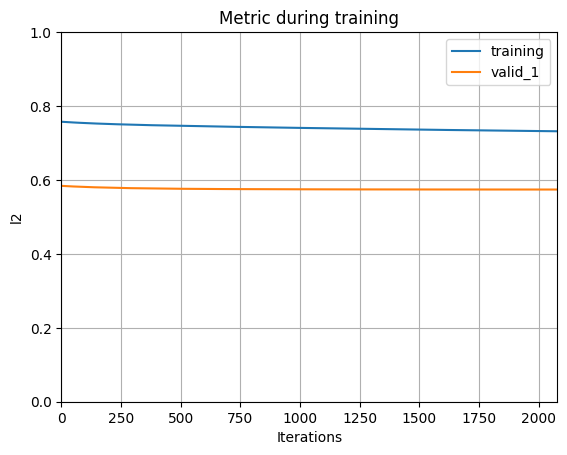

Fold Val R2 score is: 0.016628418330127293
Fold Val Weighted R2 score is: 0.01709086711597463
Memory usage of dataframe is 1132.59 MB


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [00:06<00:00, 23.31it/s]


Memory usage after optimization is: 1132.59 MB
Decreased by 0.0%
Memory usage of dataframe is 283.15 MB


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [00:01<00:00, 93.12it/s]


Memory usage after optimization is: 283.15 MB
Decreased by 0.0%
[50]	training's l2: 0.691855	valid_1's l2: 0.830762
[100]	training's l2: 0.690203	valid_1's l2: 0.829447
[150]	training's l2: 0.688819	valid_1's l2: 0.828443
[200]	training's l2: 0.687624	valid_1's l2: 0.827607
[250]	training's l2: 0.686602	valid_1's l2: 0.826922
[300]	training's l2: 0.685718	valid_1's l2: 0.826364
[350]	training's l2: 0.68491	valid_1's l2: 0.825908
[400]	training's l2: 0.684175	valid_1's l2: 0.825515
[450]	training's l2: 0.683526	valid_1's l2: 0.825161
[500]	training's l2: 0.68293	valid_1's l2: 0.824869
[550]	training's l2: 0.682387	valid_1's l2: 0.824598
[600]	training's l2: 0.681867	valid_1's l2: 0.824358
[650]	training's l2: 0.681361	valid_1's l2: 0.824146
[700]	training's l2: 0.680863	valid_1's l2: 0.823947
[750]	training's l2: 0.680383	valid_1's l2: 0.823768
[800]	training's l2: 0.679895	valid_1's l2: 0.823612
[850]	training's l2: 0.679382	valid_1's l2: 0.823432
[900]	training's l2: 0.678879	valid_1'

<Figure size 640x480 with 0 Axes>

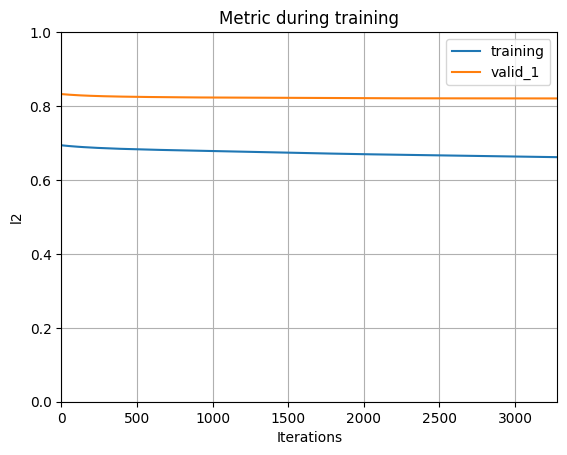

Fold Val R2 score is: 0.013509905979311454
Fold Val Weighted R2 score is: 0.014218341390055844
R2 score is: 0.005963778250501317
Weighted R2 score is: 0.0061142914425719175


In [76]:
lgb_train(sample_train_df, sample_y_sr)